In [17]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl

from tensorflow.keras.layers import Input

from app.src.yolo3.model import *
from app.src.yolo3.detect import *

from app.src.utils.image import *
from app.src.utils.datagen import *
from app.src.utils.fixes import *

import base64

fix_tf_gpu()

In [11]:
def prepare_model(approach):
    '''
    Prepare the YOLO model
    '''
    global input_shape, class_names, anchor_boxes, num_classes, num_anchors, model

    # shape (height, width) of the imput image
    input_shape = (416, 416)

    # class names
    if approach == 1:
        class_names = ['H', 'V', 'W']

    elif approach == 2:
        class_names  = ['W','WH','WV','WHV']

    elif approach == 3:
        class_names  = ['W']

    else:
        raise NotImplementedError('Approach should be 1, 2, or 3')

    # anchor boxes
    if approach == 1:
        anchor_boxes = np.array(
            [
            np.array([[ 76,  59], [ 84, 136], [188, 225]]) /32, # output-1 anchor boxes
            np.array([[ 25,  15], [ 46,  29], [ 27,  56]]) /16, # output-2 anchor boxes
            np.array([[ 5,    3], [ 10,   8], [ 12,  26]]) /8   # output-3 anchor boxes
            ],
            dtype='float64'
        )
    else:
        anchor_boxes = np.array(
            [
            np.array([[ 73, 158], [128, 209], [224, 246]]) /32, # output-1 anchor boxes
            np.array([[ 32,  50], [ 40, 104], [ 76,  73]]) /16, # output-2 anchor boxes
            np.array([[ 6,   11], [ 11,  23], [ 19,  36]]) /8   # output-3 anchor boxes
            ],
            dtype='float64'
        )

    # number of classes and number of anchors
    num_classes = len(class_names)
    num_anchors = anchor_boxes.shape[0] * anchor_boxes.shape[1]

    # input and output
    input_tensor = Input( shape=(input_shape[0], input_shape[1], 3) ) # input
    num_out_filters = ( num_anchors//3 ) * ( 5 + num_classes )        # output

    # build the model
    model = yolo_body(input_tensor, num_out_filters)

    # load weights
    weight_path = f'app/model_data/weights/pictor-ppe-v302-a{approach}-yolo-v3-weights.h5'
    model.load_weights( weight_path )

In [12]:
def get_detection(img):
    # save a copy of the img
    act_img = img.copy()

    # shape of the image
    ih, iw = act_img.shape[:2]

    # preprocess the image
    img = letterbox_image(img, input_shape)
    img = np.expand_dims(img, 0)
    image_data = np.array(img) / 255.

    # raw prediction from yolo model
    prediction = model.predict(image_data)

    # process the raw prediction to get the bounding boxes
    boxes = detection(
        prediction,
        anchor_boxes,
        num_classes,
        image_shape = (ih, iw),
        input_shape = (416,416),
        max_boxes = 10,
        score_threshold=0.3,
        iou_threshold=0.45,
        classes_can_overlap=False)

    # convert tensor to numpy
    boxes = boxes[0].numpy()

    # draw the detection on the actual image
    return draw_detection(act_img, boxes, class_names)

In [13]:
def plt_imshow(img):
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')

In [18]:
def search_items(img):
    # img is b64 encoded
    img = base64.b64decode(img)
    img = np.frombuffer(img, np.uint8)
    # open the decoded image
    img = cv2.imdecode(img, cv2.IMREAD_COLOR)
    img = letterbox_image(img, input_shape)
    # get the detection
    img = get_detection(img)
    # encode the image
    _, img = cv2.imencode('.jpg', img)
    img = base64.b64encode(img)
    return img.decode('utf-8')

In [19]:
prepare_model(approach=1)

1/1 [==============================] - 1s 584ms/step


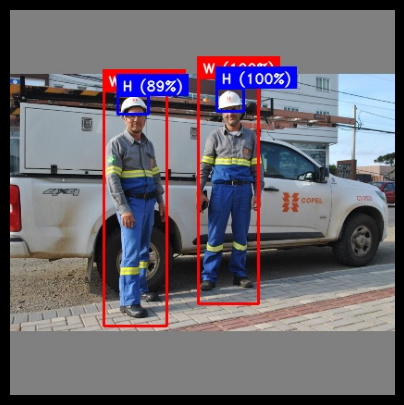

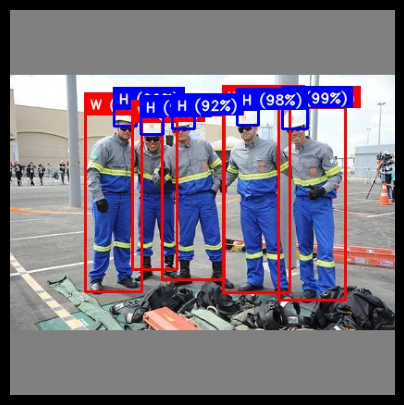

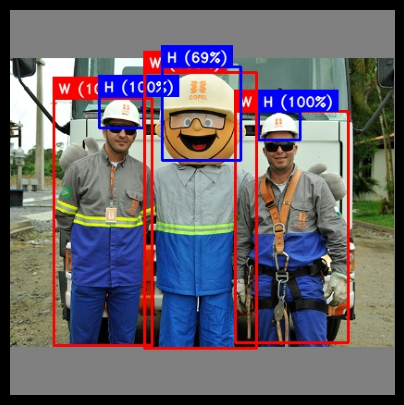

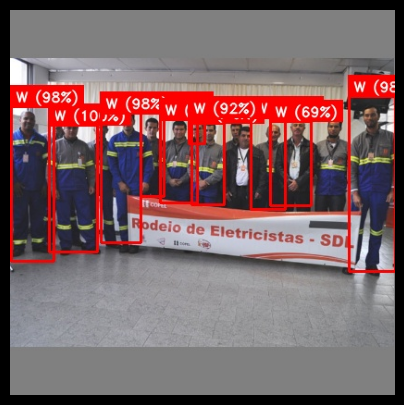

In [22]:
for i in range(1, 5):
    import base64

    with open(f'assets/img/t{i}.jpg', 'rb') as img:
        # read the image
        img = img.read()
        img = base64.b64encode(img)
        img = img.decode('utf-8')
        img = search_items(img)
        img = base64.b64decode(img)
        img = np.frombuffer(img, np.uint8)
        img = cv2.imdecode(img, cv2.IMREAD_COLOR)
        plt_imshow(img[:, :, ::-1])